### Data Analysis
#### This notebook is here to analyse the data we preprocessed, in order to focus on the area that are mainly concerned by wildfires.

#### If you want to get the final dataset without the explanation, run the file **/data/prep/data_analysis.py**.

#### Before running any cells make sure that the file **dataset_pre_analysis.csv** is in the folder **storage/dataset**, if not you have to run **/data/prep/data_preprocessing.py**.


In [1]:
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
current_dir  = os.getcwd()
dataset_path = os.path.join(current_dir, '..', 'storage', 'dataset',"dataset_pre_analysis.csv")
dataset = pd.read_csv(dataset_path)
# convert IS_FIRE to float
dataset["IS_FIRE"] = dataset["IS_FIRE"].astype(float)

# Group by CELL_LAT and CELL_LON and select those who have IS_FIRE = 1.0
df = dataset.groupby(["CELL_LAT", "CELL_LON"])
number_cell = len(df)
fire_cells = df['IS_FIRE'].max().reset_index()
fire_cells = fire_cells[fire_cells['IS_FIRE'] == 1.0]
#count the fire cells
count_fire_cells = fire_cells.shape[0]

print("Only" ,count_fire_cells,"out of",number_cell,"are on fire at least one time between 2010 and 2021.")

Only 1278 out of 6789 are on fire at least one time between 2010 and 2021.


#### As only 1278 out of 6789 are on fire at least one time, we have to reduce the dimensionality of the dataset in order to focus on the area that are concerned by wildfires.

#### Let's see it on a map, next we'll plot every cell of the dataset and every one that as a red dot in it means that there is at least one wildfire in the cell in between 2010 and 2021.

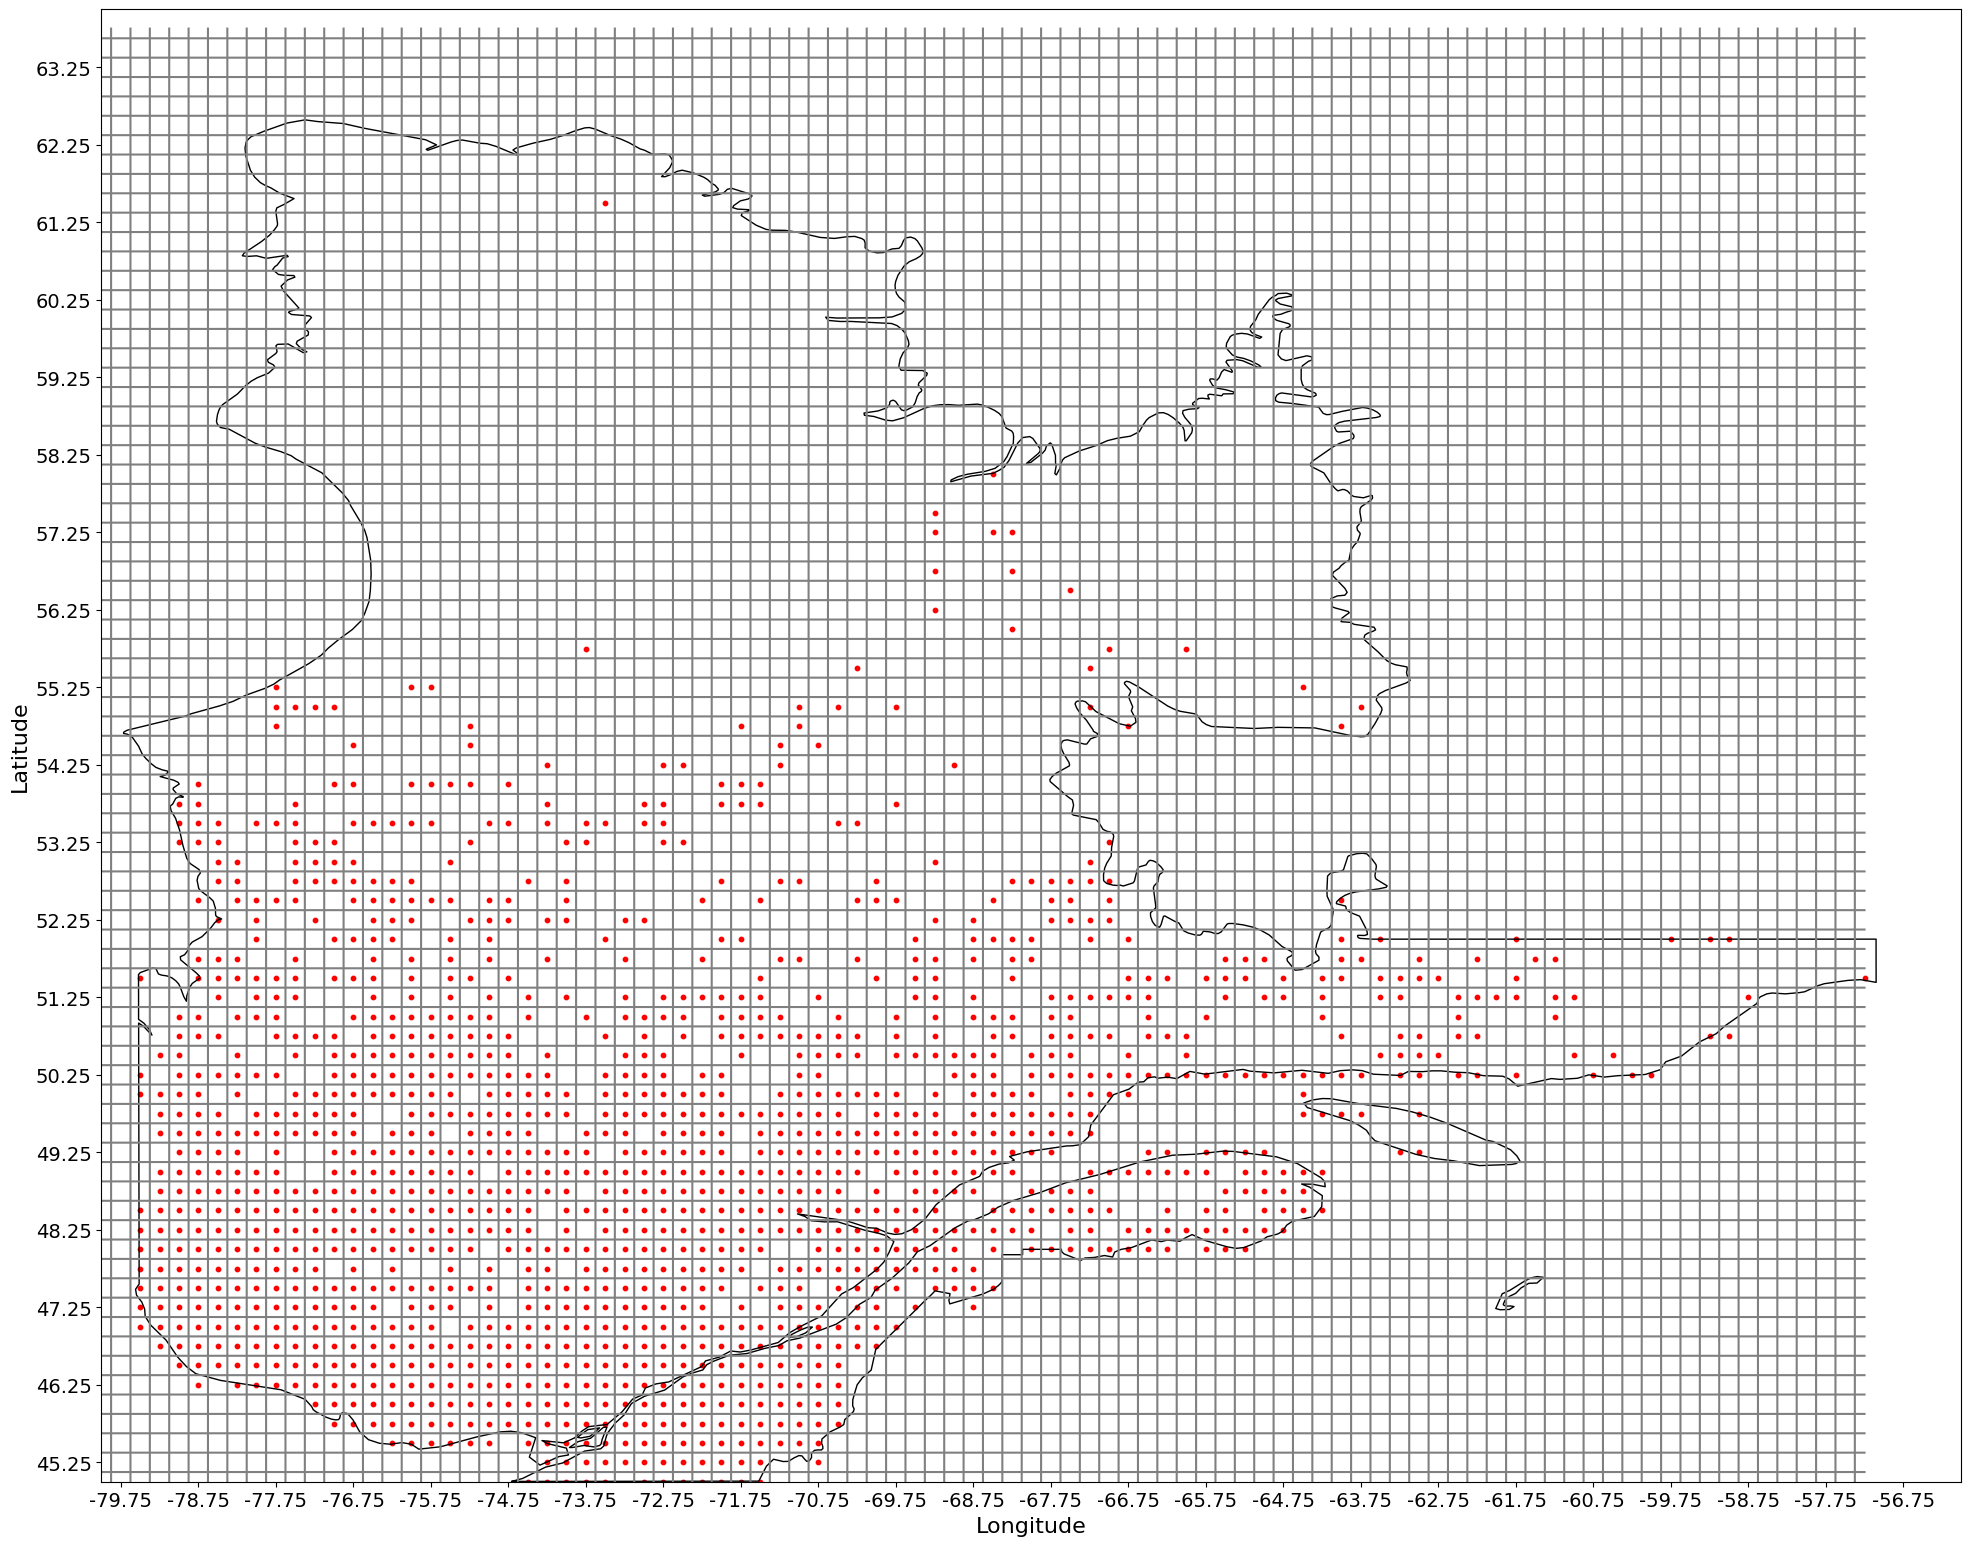

In [2]:
import geopandas as gpd
from data.view.plot_map import *
url = "https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces.zip"
canada = gpd.read_file(url)

# Filtrer pour obtenir uniquement le Québec
quebec = canada[canada["name"] == "Québec"]
fire_cells_coords = list(fire_cells[['CELL_LON', 'CELL_LAT']].itertuples(index=False, name=None))
fig,ax = plot_qc_map(quebec)
for lon, lat in fire_cells_coords:
    ax.scatter(lon, lat, color='red', s=10)
plt.show()

In [3]:
dataset_fire_path = os.path.join(current_dir, '..', 'storage', 'dataset',"dataset_fire_cleaned.csv")
df_fire = pd.read_csv(dataset_fire_path)
# Convertir les colonnes en float (en s'assurant qu'il n'y a pas d'erreurs de conversion)
df_fire["LONGITUDE"] = pd.to_numeric(df_fire["LONGITUDE"], errors='coerce')
df_fire["LATITUDE"] = pd.to_numeric(df_fire["LATITUDE"], errors='coerce')

# Filtrer les données
filtered_df = df_fire[(df_fire["LONGITUDE"] >= -79.5) & (df_fire["LONGITUDE"] <= -64) &
                 (df_fire["LATITUDE"] >= 45.25) & (df_fire["LATITUDE"] <= 52)]

# Compter les résultats
count = len(filtered_df)
countfull = len(df_fire)
print(f"{round(count/countfull*100,2)}% of fires are contained -79.5 and -58.75 and the latitudes 45.25 and 52")

91.84% of fires are contained -79.5 and -58.75 and the latitudes 45.25 and 52


#### As 91.84% of wildfires are contained -79.5 and -58.75 and the latitudes 45.25 and 52, so we will restrict our dataset to theses latitudes and longitudes, we also have to recalculate the coordinates since we changed the coordinate system.

In [4]:
filtered_dataset = dataset[(dataset["CELL_LON"] >= -79.5) & (dataset["CELL_LON"] <= -64) &
                 (dataset["CELL_LAT"] >= 45.25) & (dataset["CELL_LAT"] <= 52)]
filtered_dataset[["COORDINATES_LAT","COORDINATES_LON" ]] = ((filtered_dataset[["CELL_LAT", "CELL_LON"]]
                                                            - [45.25,-79.5]) / [0.25,0.25]).astype(int)

#### We will now plot the area we are focusing on, it is the one contained in the green rectangle.

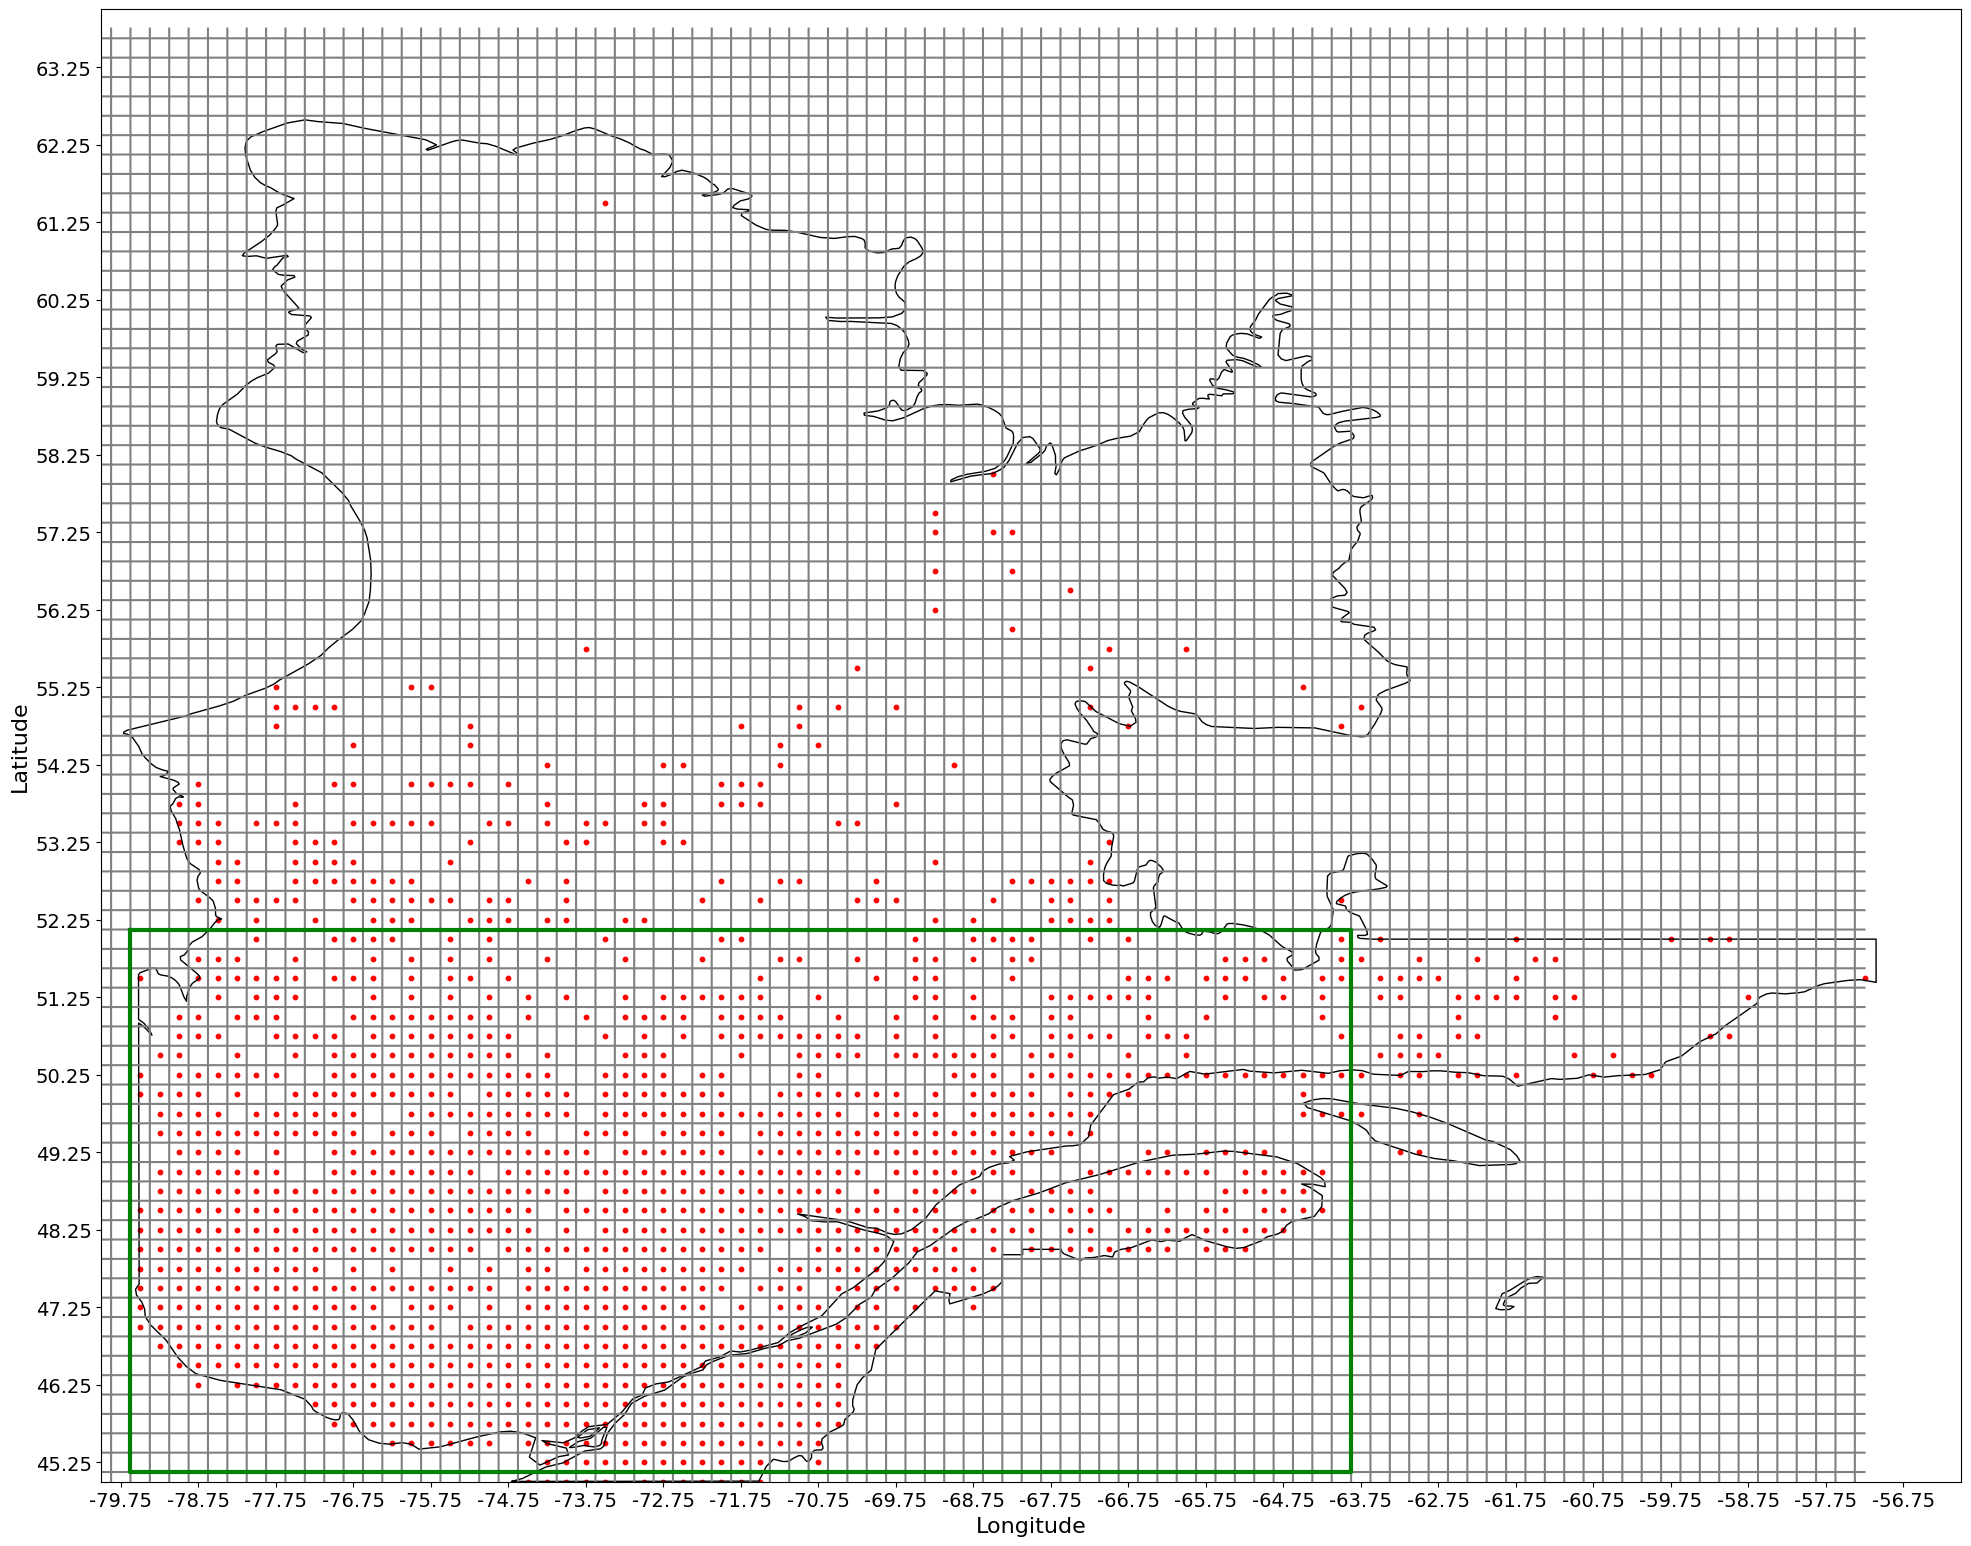

In [5]:
from data.view.plot_map import *
fire_cells_coords = list(fire_cells[['CELL_LON', 'CELL_LAT']].itertuples(index=False, name=None))
fig,ax = plot_qc_map(quebec)
for lon, lat in fire_cells_coords:
    ax.scatter(lon, lat, color='red', s=10)
ax.plot([-79.625,-79.625,-63.875,-63.875,-79.625],[52.125,45.125,45.125,52.125,52.125],color='green',linestyle='-',linewidth=3)
plt.show()

#### We will now erase the datapoints that are in the ocean.

In [6]:
from data.view.pixel_label import *

In [7]:
date = '2019-08-01'
filtered_dataset_date = filtered_dataset[filtered_dataset['DATE'] == date]
# Créer une géométrie de points avec latitudes et longitudes
filtered_dataset_date['IN_OCEAN'] = filtered_dataset_date.apply(lambda row: is_cell_in_ocean(row['CELL_LAT'], row['CELL_LON'], ocean_gdf), axis=1)


# Extraire uniquement les points situés dans l'océan
points_in_ocean = filtered_dataset_date[filtered_dataset_date['IN_OCEAN']]

# Extraire la liste des latitudes et longitudes des points dans l'océan
lat_lon_list_ocean = points_in_ocean[['CELL_LAT', 'CELL_LON']].values.tolist()
lat_lon_set_ocean = set(map(tuple, lat_lon_list_ocean))

# Supprimer les lignes de filtered_dataset qui ont des coordonnées dans l'océan
filtered_dataset_no_ocean = filtered_dataset[~filtered_dataset[['CELL_LAT', 'CELL_LON']].apply(tuple, axis=1).isin(lat_lon_set_ocean)]


#### Let's see which points contained in the green rectangle are in the ocean. They are ploted in the map as the blue points.

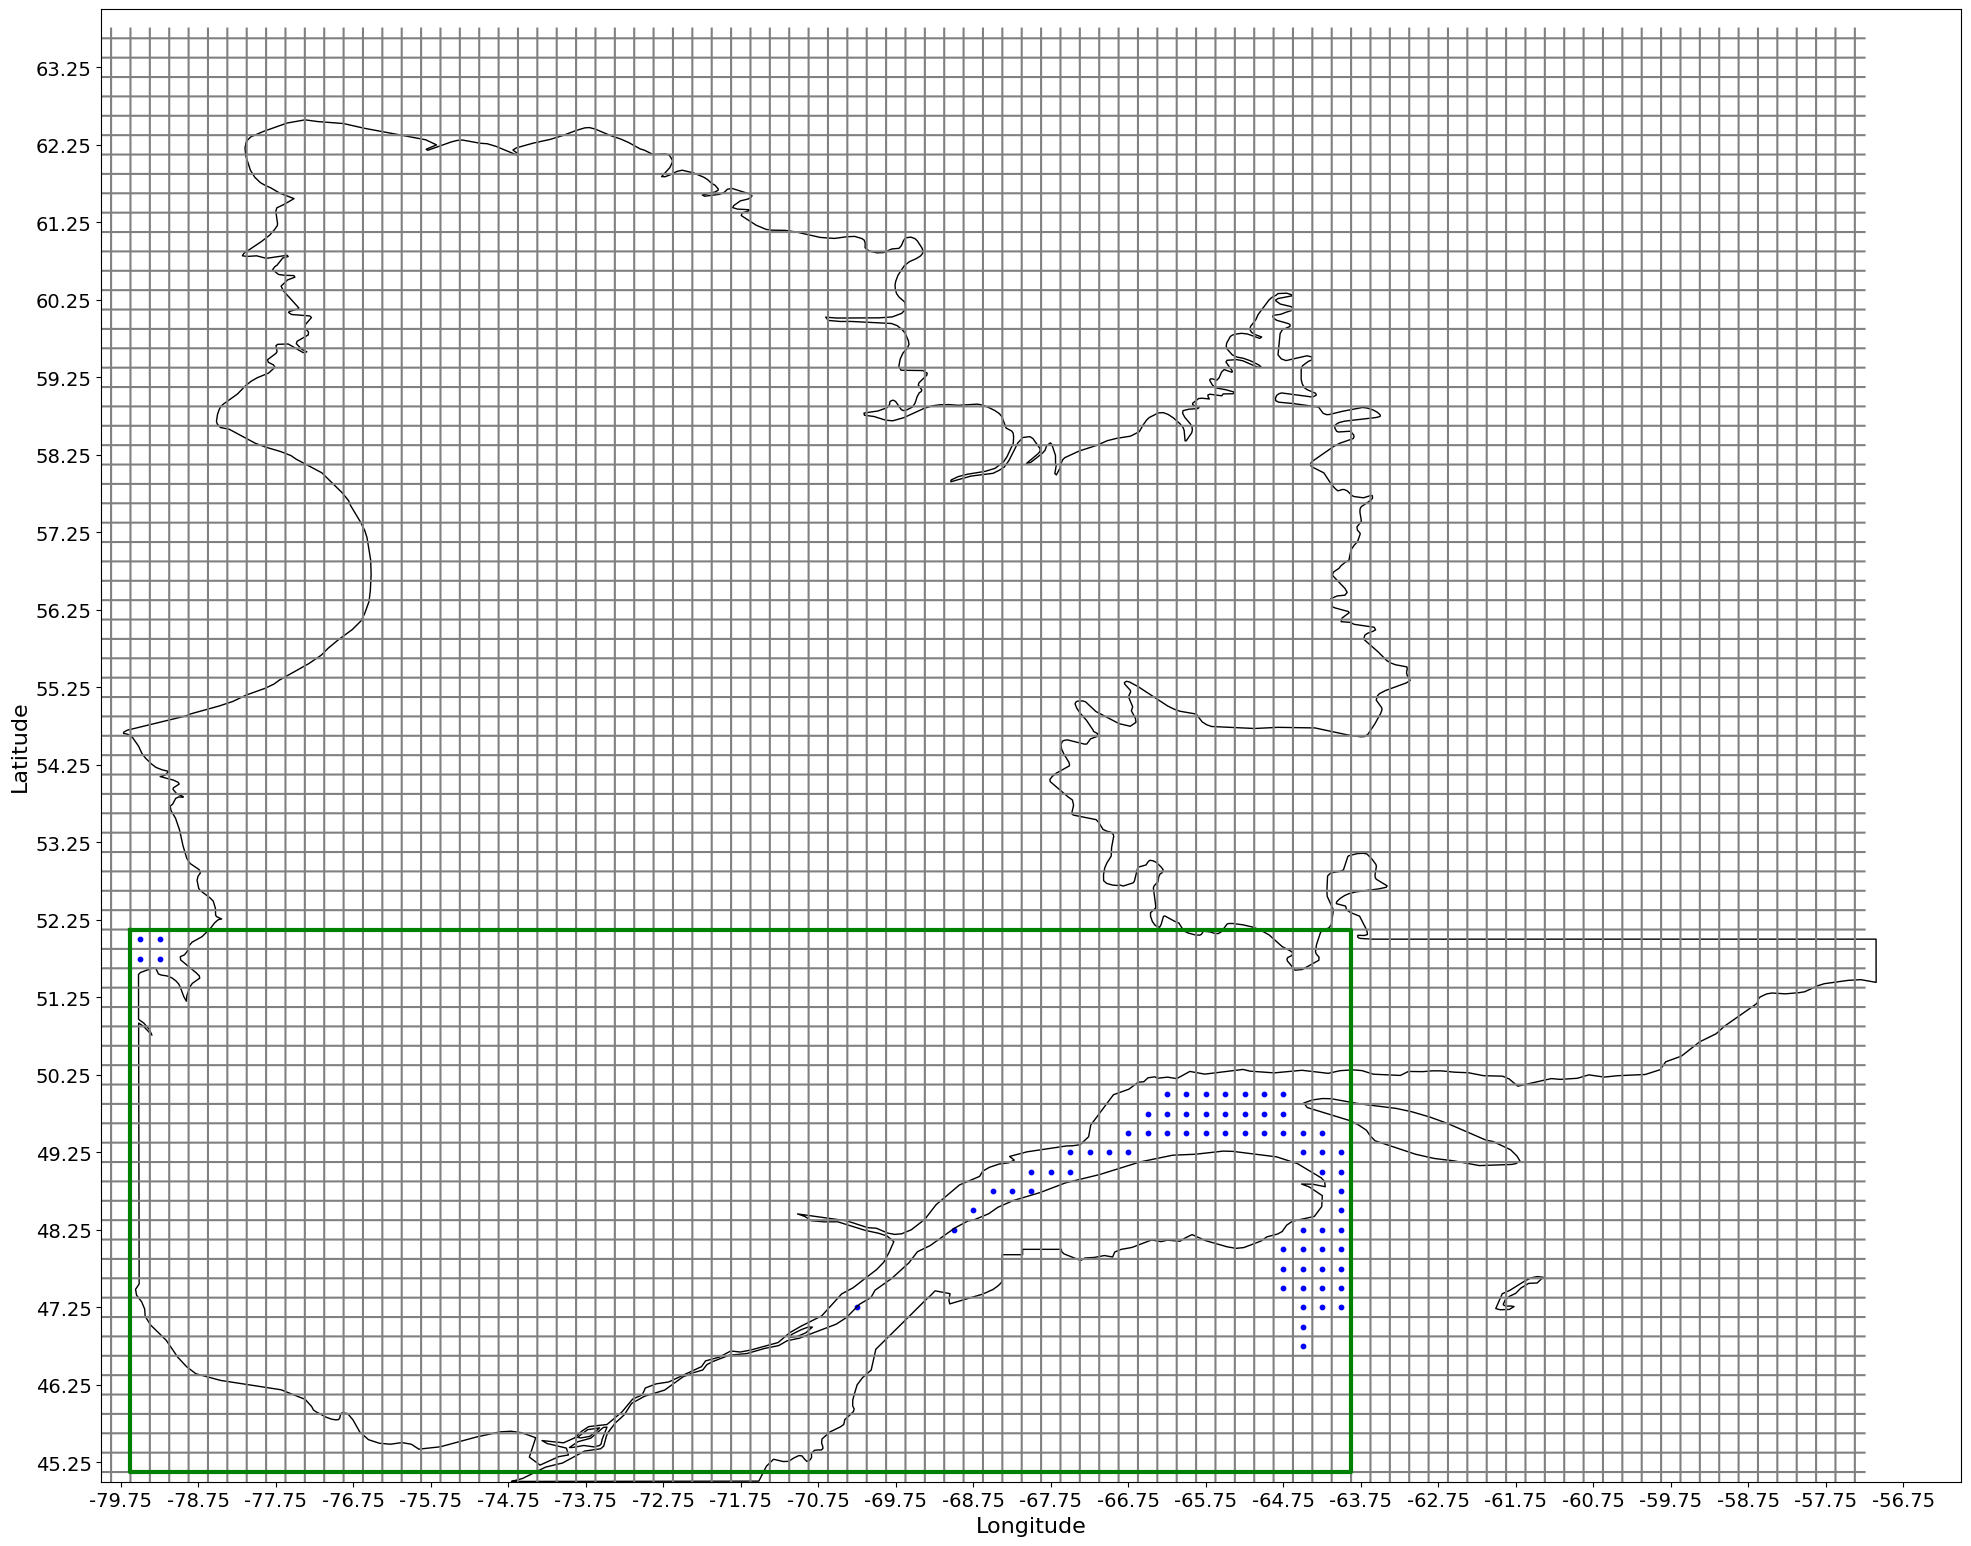

In [8]:
from data.view.plot_map import *
fire_cells_coords = list(fire_cells[['CELL_LON', 'CELL_LAT']].itertuples(index=False, name=None))
fig,ax = plot_qc_map(quebec)
for coo in lat_lon_list_ocean :
    ax.scatter(coo[1], coo[0], color='blue', s=10)
ax.plot([-79.625,-79.625,-63.875,-63.875,-79.625],[52.125,45.125,45.125,52.125,52.125],color='green',linestyle='-',linewidth=3)
plt.show()

#### We will now erase the datapoints that aren't in Québec.

In [9]:
date = '2019-08-01'
filtered_dataset_no_ocean_date = filtered_dataset_no_ocean[filtered_dataset_no_ocean['DATE'] == date]
# Créer une géométrie de points avec latitudes et longitudes
filtered_dataset_no_ocean_date['IN_QC'] = filtered_dataset_no_ocean_date.apply(lambda row: is_cell_in_quebec(row['CELL_LAT'], row['CELL_LON'], quebec), axis=1)


# Extraire uniquement les points situés en dehors du québec
points_out_quebec = filtered_dataset_no_ocean_date[filtered_dataset_no_ocean_date['IN_QC']==False]

# Extraire la liste des latitudes et longitudes des points dans l'océan
lat_lon_list_notqc = points_out_quebec[['CELL_LAT', 'CELL_LON']].values.tolist()
lat_lon_set_notqc = set(map(tuple, lat_lon_list_notqc))

# Supprimer les lignes de filtered_dataset qui ont des coordonnées dans l'océan
filtered_dataset_no_ocean_qconly = filtered_dataset_no_ocean[~filtered_dataset_no_ocean[['CELL_LAT', 'CELL_LON']].apply(tuple, axis=1).isin(lat_lon_set_notqc)]


#### Let's see which points contained in the green rectangle are not in Québec. They are ploted in the map as the black points. Some may are not in other territory other than Québec, but they are in the ocean and we couldn't erase them with the previous functions, but we can do it now.

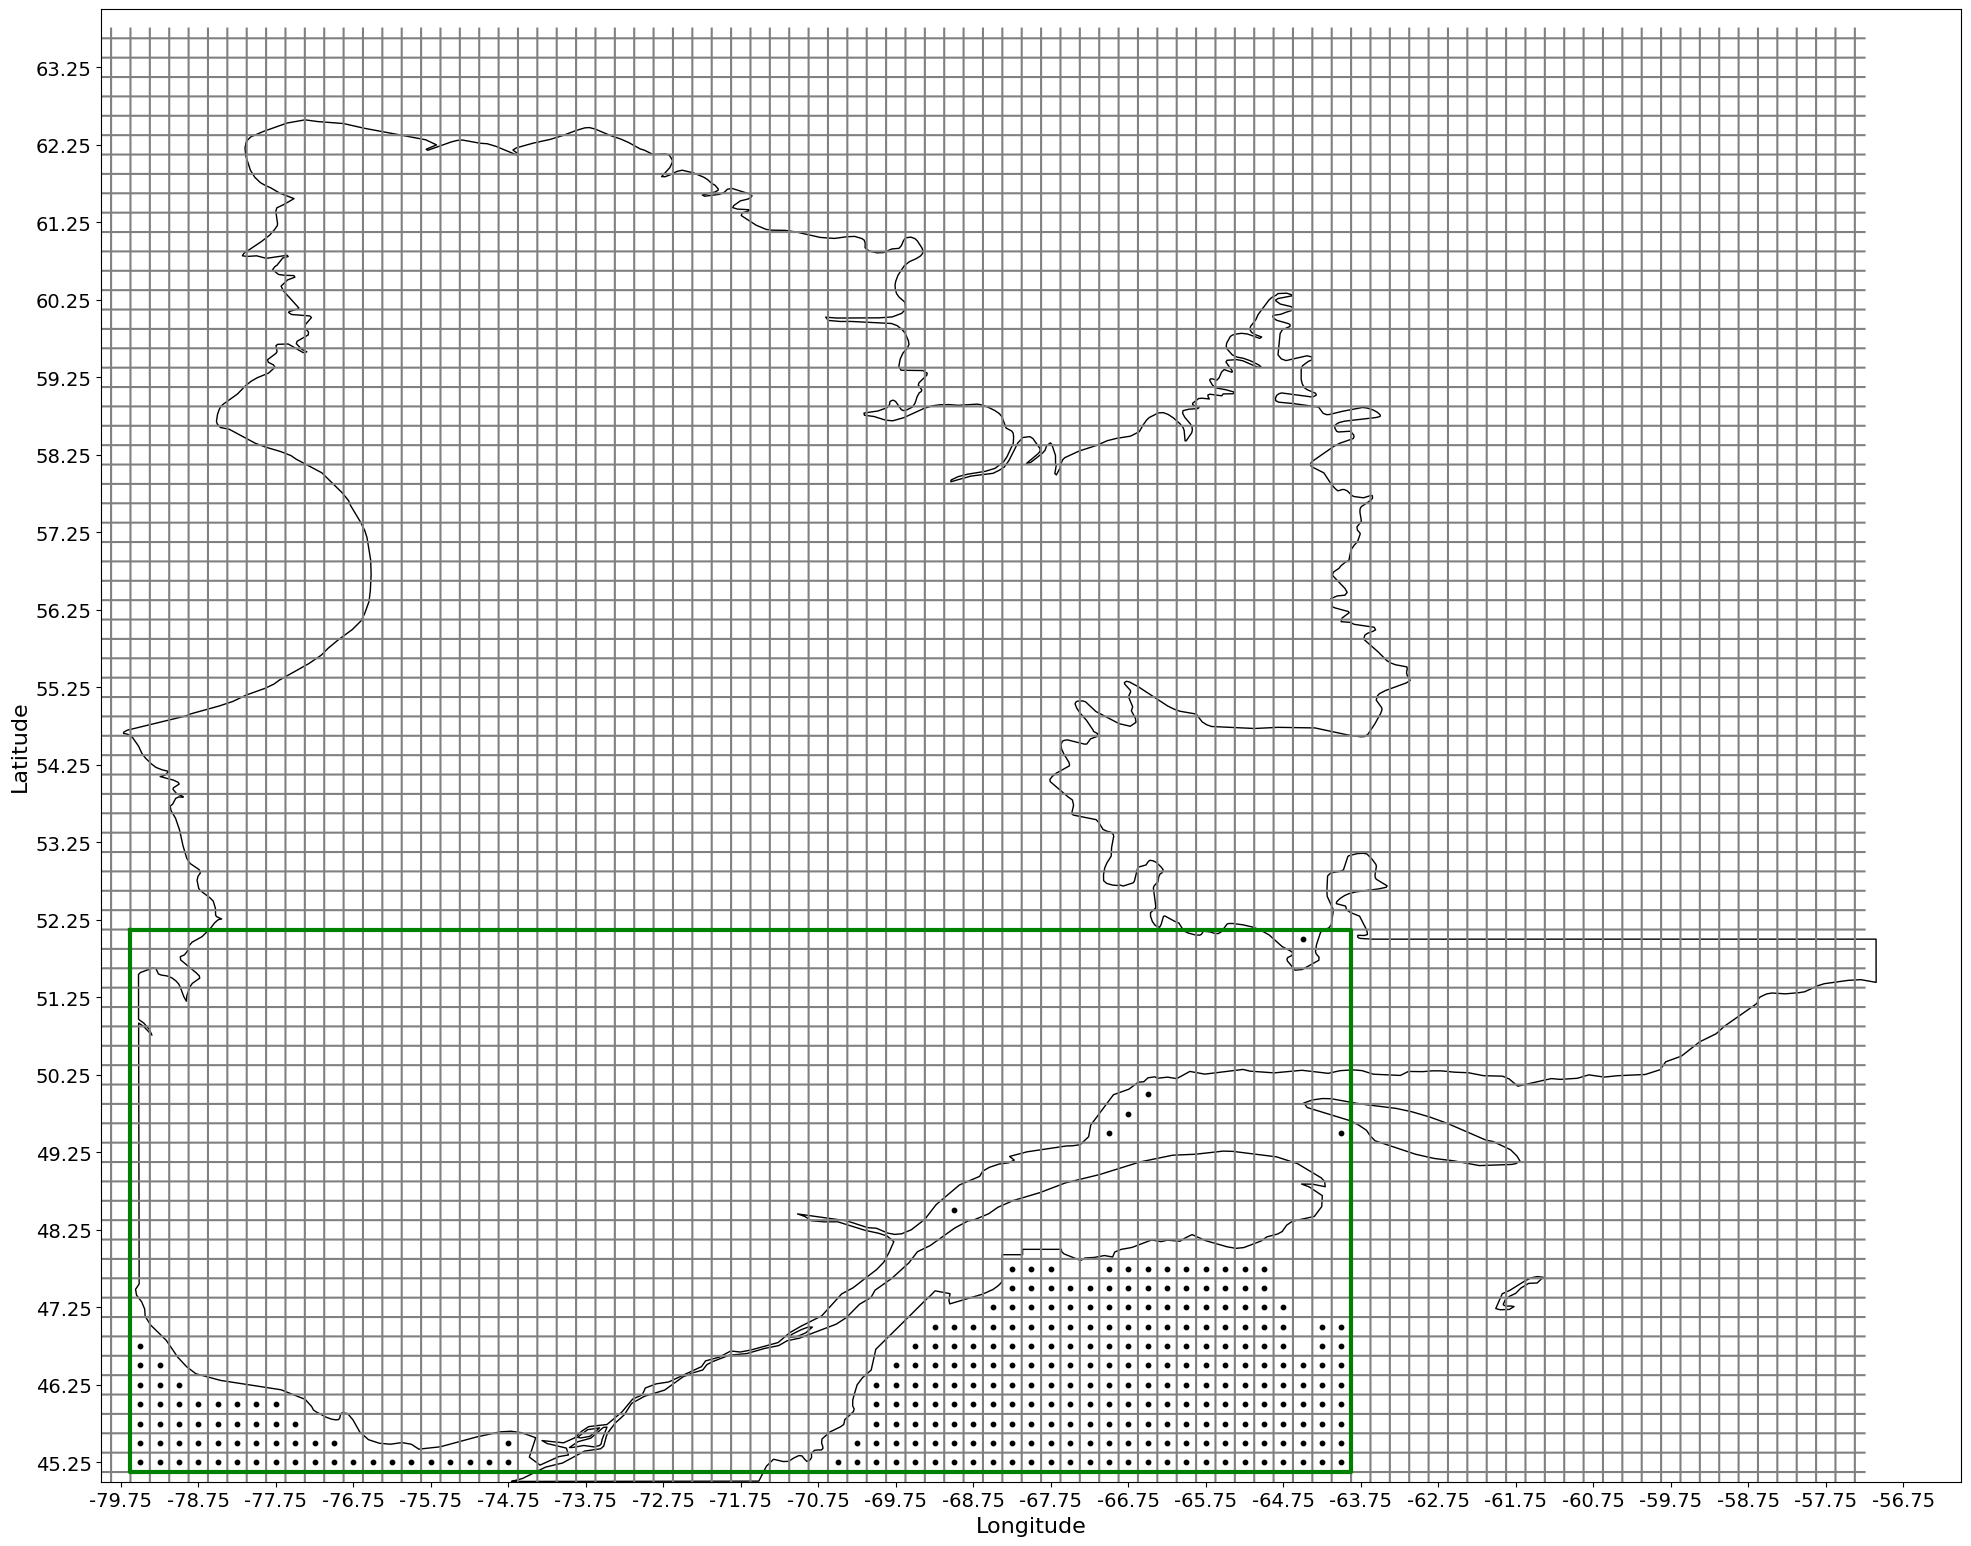

In [10]:
from data.view.plot_map import *
fire_cells_coords = list(fire_cells[['CELL_LON', 'CELL_LAT']].itertuples(index=False, name=None))
fig,ax = plot_qc_map(quebec)
for coo in lat_lon_list_notqc :
    ax.scatter(coo[1], coo[0], color='black', s=10)
ax.plot([-79.625,-79.625,-63.875,-63.875,-79.625],[52.125,45.125,45.125,52.125,52.125],color='green',linestyle='-',linewidth=3)
plt.show()

#### So in a nutshell now the dataset is are the cells contained in the green rectangle without the pixels that are within other territory than Québec and the ocean, so it is the following map with the orange pixels for each day between 2010 and 2021, without the blue and black ones. And then the geographical analysis will be finished.

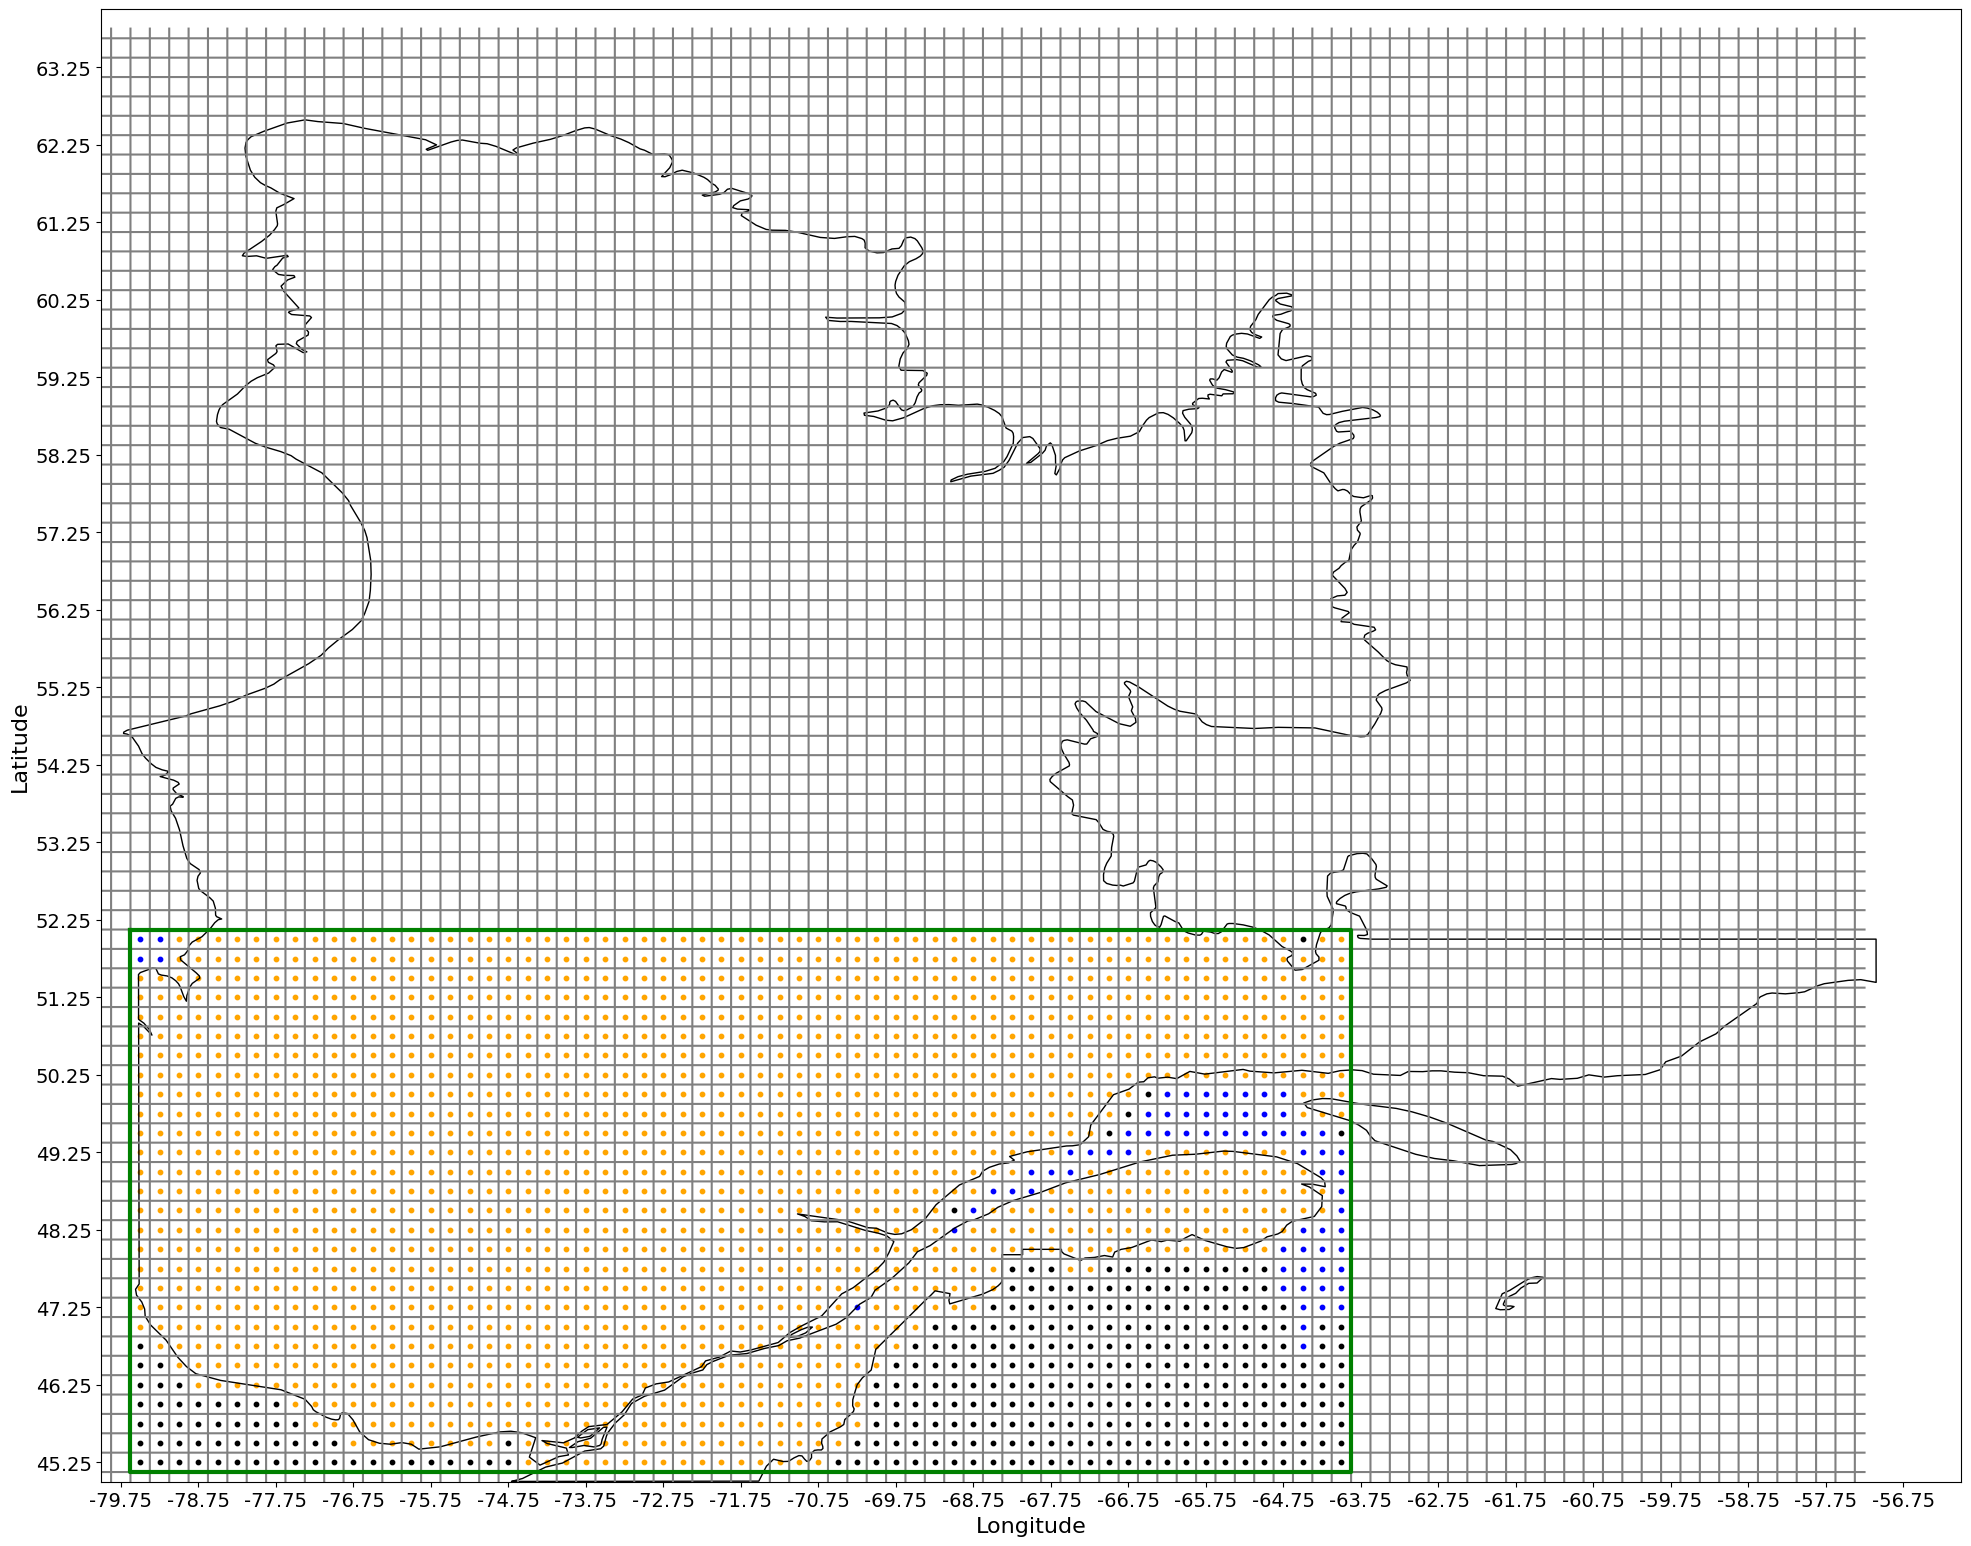

In [11]:
from data.view.plot_map import *
fire_cells_coords = list(fire_cells[['CELL_LON', 'CELL_LAT']].itertuples(index=False, name=None))
fig,ax = plot_qc_map(quebec)
for coo in lat_lon_list_notqc :
    ax.scatter(coo[1], coo[0], color='black', s=10)
ax.plot([-79.625,-79.625,-63.875,-63.875,-79.625],[52.125,45.125,45.125,52.125,52.125],color='green',linestyle='-',linewidth=3)
for coo in lat_lon_list_ocean :
    ax.scatter(coo[1], coo[0], color='blue', s=10)
filtered_dataset_no_ocean_qconly_date = filtered_dataset_no_ocean_qconly[filtered_dataset_no_ocean_qconly['DATE'] == date]
lat_lon_list= filtered_dataset_no_ocean_qconly_date[['CELL_LAT', 'CELL_LON']].values.tolist()
lat_lon_set = set(map(tuple, lat_lon_list))
for coo in lat_lon_set :
    ax.scatter(coo[1], coo[0], color='orange', s=10)
plt.show()

#### We know naturraly that some time periods aren't concerned about forest fire, like the winter season for example. We will see for each year which period have no fire at all and erase it from the dataset.

In [12]:
df_filtered = df_fire[
    (df_fire["CELL_LON"] >= -79.5) & (df_fire["CELL_LON"] <= -64) &
    (df_fire["CELL_LAT"] >= 45.25) & (df_fire["CELL_LAT"] <= 52)
]

# Convertir les dates en datetime pour les manipulations
df_filtered["REP_DATE"] = pd.to_datetime(df_filtered["REP_DATE"])

# Extraire l'année, le mois, le jour
df_filtered["year"] = df_filtered["REP_DATE"].dt.year
df_filtered["month"] = df_filtered["REP_DATE"].dt.month
df_filtered["day"] = df_filtered["REP_DATE"].dt.day

# Trouver la date la plus tôt et la plus tard pour chaque année
earliest_per_year = df_filtered.groupby("year")["REP_DATE"].min()
latest_per_year = df_filtered.groupby("year")["REP_DATE"].max()

# Trouver le mois et le jour les plus tôt et les plus tard parmi les dates minimales et maximales
earliest_month_day = earliest_per_year.dt.strftime('%m-%d').min()
latest_month_day = latest_per_year.dt.strftime('%m-%d').max()

# Résultat
print("Global earliest month-day:", earliest_month_day)
print("Global latest month-day:", latest_month_day)

Global earliest month-day: 03-11
Global latest month-day: 12-07


#### We see that before 3<sup>rd</sup> March and after 7<sup>th</sup> December there is no fire at all, so we erase the period between the 7<sup>th</sup> December and 31<sup>st</sup> December, and the 1<sup>st</sup> January and 3<sup>rd</sup> March.

In [13]:
import pandas as pd

# Assurez-vous que la colonne DATE est de type datetime
filtered_dataset_no_ocean_qconly["DATE"] = pd.to_datetime(filtered_dataset_no_ocean_qconly["DATE"], errors='coerce')

# Créer un masque pour exclure les dates entre le 7 décembre et le 31 décembre
mask_december_exclude = (filtered_dataset_no_ocean_qconly["DATE"].dt.month == 12) & (filtered_dataset_no_ocean_qconly["DATE"].dt.day > 7)

# Créer un masque pour exclure les dates entre le 1er janvier et le 11 mars (y compris le 1er janvier, mais excluant le 11 mars)
mask_jan_march_exclude = ((filtered_dataset_no_ocean_qconly["DATE"].dt.month == 1) | (filtered_dataset_no_ocean_qconly["DATE"].dt.month == 3)) & \
                          ((filtered_dataset_no_ocean_qconly["DATE"].dt.day >= 1) & (filtered_dataset_no_ocean_qconly["DATE"].dt.day <= 10))

# Créer un masque pour exclure toutes les dates avant le 12 mars
mask_before_march_12 = (filtered_dataset_no_ocean_qconly["DATE"].dt.month == 1) | \
                        ((filtered_dataset_no_ocean_qconly["DATE"].dt.month == 2) & (filtered_dataset_no_ocean_qconly["DATE"].dt.day <= 28)) | \
                        ((filtered_dataset_no_ocean_qconly["DATE"].dt.month == 3) & (filtered_dataset_no_ocean_qconly["DATE"].dt.day <= 10))

# Filtrer les données selon ces critères
filtered_data = filtered_dataset_no_ocean_qconly[~(mask_december_exclude | mask_jan_march_exclude | mask_before_march_12)]
# filtered_data.to_csv("dataset_end_analysis.csv", index=False)

In [14]:
filtered_data = filtered_data.sort_values(by=['CELL_LAT', 'CELL_LON', 'DATE'])

# Ajouter une colonne indiquant si le pixel sera en feu au prochain temps
filtered_data['IS_FIRE_NEXT_DAY'] = filtered_data.groupby(['CELL_LAT', 'CELL_LON'])['IS_FIRE'].shift(-1)

# Remplacer les NaN (qui apparaissent pour le dernier temps de chaque pixel) par 0
filtered_data['IS_FIRE_NEXT_DAY'] = filtered_data['IS_FIRE_NEXT_DAY'].fillna(0).astype(int)

dataset_analysis_path = os.path.join(current_dir, '..', 'storage', 'dataset',"dataset_end_analysis.csv")
filtered_data.to_csv(dataset_analysis_path, index=False)


In [16]:
# def vectorized_haversine_formula(latitudes1, longitudes1, latitudes2, longitudes2):
#     lat1, lon1 = np.radians(latitudes1), np.radians(longitudes1)
#     lat2, lon2 = np.radians(latitudes2), np.radians(longitudes2)
#     d_haversine = 2 * 6378 * np.arcsin(np.sqrt(np.sin((lat2 - lat1) / 2) ** 2 +
#                                                np.cos(lat1) * np.cos(lat2) * np.sin((lon2 - lon1) / 2) ** 2))
#     return d_haversine
# def vectorized_cell_width_length(latitudes, longitudes, incr_lat, incr_lon):
#     # Calculer les origines des points et les points adjacents
#     origine_lat = latitudes - incr_lat / 2
#     origine_lon = longitudes - incr_lon / 2
#     point1_lat = latitudes + incr_lat / 2
#     point2_lon = longitudes + incr_lon / 2

#     # Calculer les distances (largeur et longueur)
#     largeur = round(vectorized_haversine_formula(origine_lat, origine_lon, point1_lat, origine_lon),3)
#     longueur = round(vectorized_haversine_formula(origine_lat, origine_lon, origine_lat, point2_lon),3)
#     return np.column_stack((largeur, longueur))

In [17]:
# import numpy as np
# date = '2020-08-01'
# df = filtered_data[filtered_data["DATE"]==date]
# df = df[["CELL_LAT","CELL_LON","COORDINATES_LAT","COORDINATES_LON"]]
# values = np.arange(0, 1.1, 0.1)

# # Probabilités : 0 a une probabilité de 0.2, les autres valeurs se partagent 0.8 de manière uniforme
# probs = [0.2] + [0.8 / (len(values) - 1)] * (len(values) - 1)

# # Génération des valeurs aléatoires avec les probabilités définies
# df["IS_FIRE"] = np.round(np.random.choice(values, size=len(df), p=probs),1)
# df[["CELL_WIDTH","CELL_LENGTH"]] = vectorized_cell_width_length(df["CELL_LAT"],df["CELL_LON"],0.25,0.25)
# print(df)

In [18]:
# df.to_csv("output.csv",index=False)

In [19]:
# max_lat = df["COORDINATES_LAT"].max()
# max_lon = df["COORDINATES_LON"].max()

# print("Max CELL_LAT:", max_lat)
# print("Max CELL_LON:", max_lon)
